<a href="https://colab.research.google.com/github/sophie826/sentiment_analysis/blob/main/SentimentAnalysis_MethodComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textblob vaderSentiment scikit-learn transformers torch

In [2]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
import re
import numpy as np                        # for splitting text into sentences
import matplotlib.pyplot as plt  # for drawing charts
from textblob import TextBlob    # Method 1
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Method 2
from sklearn.feature_extraction.text import CountVectorizer            # Method 3
from sklearn.naive_bayes import MultinomialNB                          # Method 3
from transformers import pipeline                                      # Method 4

**STEP 1: LOAD TEXT FILES**

In [4]:
with open("trump.txt", "r", encoding="utf-8") as f:
    trump_text = f.read()
print(f"   Total characters in file: {len(trump_text)}")

   Total characters in file: 55744


**STEP 2: SPLIT SENTENCES**

In [5]:

raw_sentences = re.split(r'(?<=[.!?])\s+', trump_text.strip())

# Only keep sentences that are long enough to be meaningful, for example, more than 20 words (cutomizable)
sentences = [s.strip() for s in raw_sentences if len(s.strip()) > 20]

print(f"✅ Found {len(sentences)} sentences")
print()
print("--- First 3 sentences as a preview ---")
for i, s in enumerate(sentences[:3]):
    print(f"  [{i+1}] {s[:80]}...")

✅ Found 815 sentences

--- First 3 sentences as a preview ---
  [1] Thank you very much, everybody....
  [2] Thank you very much to a very popular former First Lady, hopefully First Lady ag...
  [3] And I just want to say a very big hello to a special place, New York, and to an ...


**STEP 3: TRY DIFFERENT METHODS TO RUN SENTIMENT ANALYSIS**

**METHOD 1: HYBRID APPROACH - TEXTBOLB**

In [6]:
tb_scores = []

for sentence in sentences:
    blob = TextBlob(sentence)
    tb_scores.append(blob.sentiment.polarity)

# Calculate the average polarity across all sentences
tb_average = sum(tb_scores) / len(tb_scores)

# Count how many sentences are positive, neutral, and negative
tb_positive = sum(1 for s in tb_scores if s > 0.05)
tb_neutral  = sum(1 for s in tb_scores if -0.05 <= s <= 0.05)
tb_negative = sum(1 for s in tb_scores if s < -0.05)

print(f"  Average polarity score : {tb_average:+.3f}")

if tb_average > 0.05:
    print("  Overall sentiment      : 😊 POSITIVE")
elif tb_average < -0.05:
    print("  Overall sentiment      : 😞 NEGATIVE")
else:
    print("  Overall sentiment      : 😐 NEUTRAL")

print()
print(f"  Positive sentences : {tb_positive}  ({tb_positive/len(sentences)*100:.1f}%)")
print(f"  Neutral  sentences : {tb_neutral}  ({tb_neutral/len(sentences)*100:.1f}%)")
print(f"  Negative sentences : {tb_negative}  ({tb_negative/len(sentences)*100:.1f}%)")

# Show the most positive sentence TextBlob found
best_tb_score  = max(tb_scores)
best_tb_index  = tb_scores.index(best_tb_score)
worst_tb_score = min(tb_scores)
worst_tb_index = tb_scores.index(worst_tb_score)

print()
print(f"  Most POSITIVE sentence  [{best_tb_score:+.2f}]:")
print(f"    \"{sentences[best_tb_index]}...\"")
print(f"  Most NEGATIVE sentence  [{worst_tb_score:+.2f}]:")
print(f"    \"{sentences[worst_tb_index]}...\"")
print()

  Average polarity score : +0.076
  Overall sentiment      : 😊 POSITIVE

  Positive sentences : 264  (32.4%)
  Neutral  sentences : 414  (50.8%)
  Negative sentences : 137  (16.8%)

  Most POSITIVE sentence  [+1.00]:
    "Remember this, if we keep going like this, we won’t have the biggest and the best...."
  Most NEGATIVE sentence  [-1.00]:
    "She cast the deciding votes that launched the worst inflation in the history of our country...."



**METHOD 2 — CLASSIC MACHINE LEARNING - NAIVE BAYES**

In [7]:
# --- Step A: Create labels using textblob average scores ---
labels = []
for score in tb_scores:
    if score >= 0.05:
        labels.append("POSITIVE")
    elif score <= -0.05:
        labels.append("NEGATIVE")
    else:
        labels.append("NEUTRAL")

print(f"  Labels created from TEXTBLOB scores:")
print(f"    POSITIVE : {labels.count('POSITIVE')}")
print(f"    NEUTRAL  : {labels.count('NEUTRAL')}")
print(f"    NEGATIVE : {labels.count('NEGATIVE')}")
print()

# --- Step B: Convert sentences into numbers ---
# CountVectorizer counts how many times each word appears
# For example: "great economy great jobs" →  {great: 2, economy: 1, jobs: 1}
vectorizer = CountVectorizer(stop_words="english")  # ignore "the", "a", etc.
X = vectorizer.fit_transform(sentences)             # X is now a matrix of word counts

print(f"  Vocabulary size (number of unique words): {len(vectorizer.vocabulary_)}")
print(f"  Matrix shape: {X.shape}  (sentences × unique words)")
print()

# --- Step C: Train the Naive Bayes model ---
# MultinomialNB works well with word count features
model = MultinomialNB()
model.fit(X, labels)

# --- Step D: Predict sentiment for each sentence ---
predictions = model.predict(X)

nb_positive = list(predictions).count("POSITIVE")
nb_neutral  = list(predictions).count("NEUTRAL")
nb_negative = list(predictions).count("NEGATIVE")

print(f"  Training accuracy: {(predictions == labels).mean() * 100:.1f}%")
print()
print(f"  Positive sentences : {nb_positive}  ({nb_positive/len(sentences)*100:.1f}%)")
print(f"  Neutral  sentences : {nb_neutral}  ({nb_neutral/len(sentences)*100:.1f}%)")
print(f"  Negative sentences : {nb_negative}  ({nb_negative/len(sentences)*100:.1f}%)")

# --- Step E: Show the most "positive" words the model learned ---
# We look at the class probabilities the model assigned to each word
feature_names = vectorizer.get_feature_names_out()
class_index   = list(model.classes_).index("POSITIVE")
top_positive_indices = model.feature_log_prob_[class_index].argsort()[-10:]
top_positive_words   = [feature_names[i] for i in top_positive_indices]

print()
print(f"  Top words associated with POSITIVE sentiment:")
print(f"    {', '.join(top_positive_words)}")
print()

  Labels created from TEXTBLOB scores:
    POSITIVE : 265
    NEUTRAL  : 405
    NEGATIVE : 145

  Vocabulary size (number of unique words): 1377
  Matrix shape: (815, 1377)  (sentences × unique words)

  Training accuracy: 94.0%

  Positive sentences : 261  (32.0%)
  Neutral  sentences : 432  (53.0%)
  Negative sentences : 122  (15.0%)

  Top words associated with POSITIVE sentiment:
    got, really, win, right, said, beautiful, people, country, going, great



**METHOD 3 — LLM - DistilBERT**

In [8]:
# We use "cardiffnlp/twitter-roberta-base-sentiment-latest",
# a RoBERTa model trained on ~124 million tweets and fine-tuned
# for 3-class sentiment: Positive / Neutral / Negative.

# Load the 3-class sentiment pipeline
bert_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    truncation=True,   # cut sentences longer than 512 tokens
    max_length=512
)

bert_labels     = []
bert_confidence = []

# Process sentences in small batches (faster than one-by-one)
batch_size = 16
for i in range(0, len(sentences), batch_size):
    batch   = sentences[i : i + batch_size]
    results = bert_analyzer(batch)
    for result in results:
        # The model returns "positive", "neutral", "negative" (lowercase)
        # We convert to uppercase to match our other methods
        bert_labels.append(result["label"].upper())
        bert_confidence.append(result["score"])

bert_positive = bert_labels.count("POSITIVE")
bert_neutral  = bert_labels.count("NEUTRAL")
bert_negative = bert_labels.count("NEGATIVE")
avg_conf      = sum(bert_confidence) / len(bert_confidence)

print(f"  Positive sentences : {bert_positive}  ({bert_positive/len(sentences)*100:.1f}%)")
print(f"  Neutral  sentences : {bert_neutral}  ({bert_neutral/len(sentences)*100:.1f}%)")
print(f"  Negative sentences : {bert_negative}  ({bert_negative/len(sentences)*100:.1f}%)")
print(f"  Average confidence : {avg_conf:.3f}  (how sure the model is)")

# Show a couple of example predictions with confidence
print()
print("  Example predictions:")
for i in [0, 1, 2]:
    s    = sentences[i]
    lbl  = bert_labels[i]
    conf = bert_confidence[i]
    emoji = "😊" if lbl == "POSITIVE" else "😞" if lbl == "NEGATIVE" else "😐"
    print(f"    {emoji} {lbl} ({conf:.2f}) — \"{s[:70]}...\"")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

  Positive sentences : 210  (25.8%)
  Neutral  sentences : 319  (39.1%)
  Negative sentences : 286  (35.1%)
  Average confidence : 0.749  (how sure the model is)

  Example predictions:
    😊 POSITIVE (0.98) — "Thank you very much, everybody...."
    😊 POSITIVE (0.98) — "Thank you very much to a very popular former First Lady, hopefully Fir..."
    😊 POSITIVE (0.98) — "And I just want to say a very big hello to a special place, New York, ..."


**STEP 4: COMPARE RESULTS**

  Method           Positive    Neutral   Negative
  -----------------------------------------------
  TextBlob            32.4%      50.8%      16.8%
  Naive Bayes         32.0%      53.0%      15.0%
  RoBERTa             25.8%      39.1%      35.1%



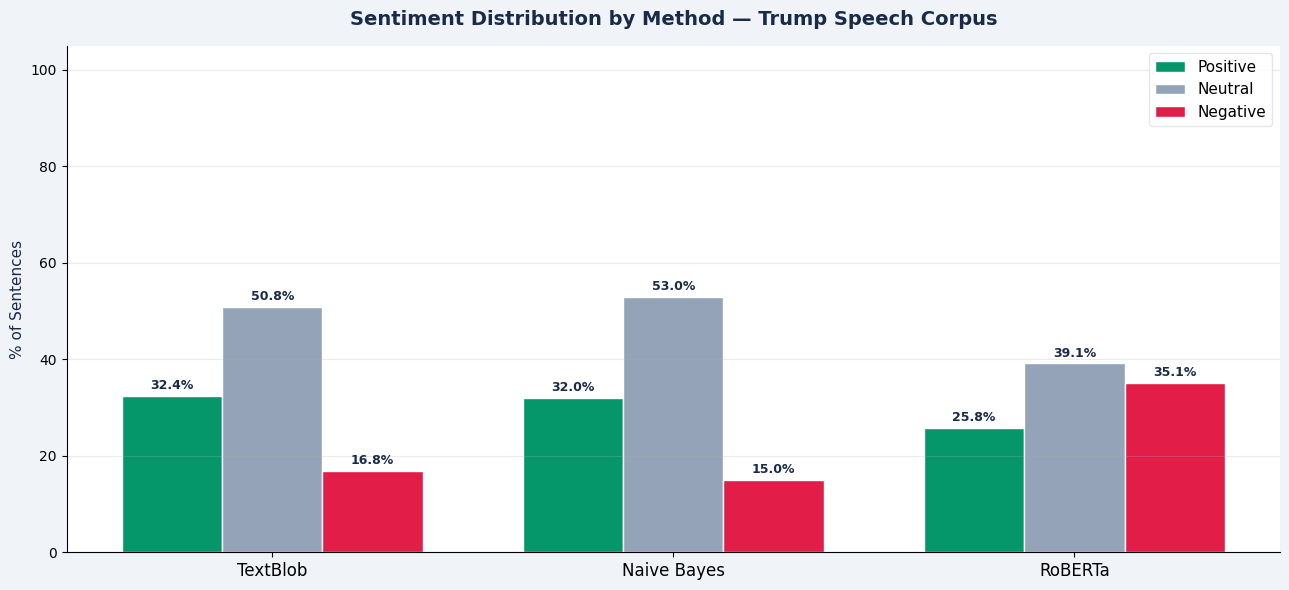

In [9]:
methods = ["TextBlob", "Naive Bayes", "RoBERTa"]

# Collect % for each category from each method
positive_pcts = [
    tb_positive    / len(sentences) * 100,
    nb_positive    / len(sentences) * 100,
    bert_positive  / len(sentences) * 100,
]
neutral_pcts = [
    tb_neutral     / len(sentences) * 100,
    nb_neutral     / len(sentences) * 100,
    bert_neutral   / len(sentences) * 100,   # RoBERTa now has Neutral
]
negative_pcts = [
    tb_negative    / len(sentences) * 100,
    nb_negative    / len(sentences) * 100,
    bert_negative  / len(sentences) * 100,
]

# Print a simple summary table
print(f"  {'Method':<14}  {'Positive':>9}  {'Neutral':>9}  {'Negative':>9}")
print("  " + "-" * 47)
for i, m in enumerate(methods):
    print(f"  {m:<14}  {positive_pcts[i]:>8.1f}%  "
          f"{neutral_pcts[i]:>8.1f}%  {negative_pcts[i]:>8.1f}%")
print()

# --- Build the chart ---
fig, ax = plt.subplots(figsize=(13, 6))
fig.patch.set_facecolor("#F0F4F8")
ax.set_facecolor("white")

x     = np.arange(len(methods))  # x positions for the 4 method groups
width = 0.25                      # width of each bar

# Three bars per group, shifted left / centre / right
bars_pos = ax.bar(x - width, positive_pcts, width,
                  label="Positive", color="#059669",
                  edgecolor="white", linewidth=1.0)
bars_neu = ax.bar(x,          neutral_pcts,  width,
                  label="Neutral",  color="#94A3B8",
                  edgecolor="white", linewidth=1.0)
bars_neg = ax.bar(x + width, negative_pcts, width,
                  label="Negative", color="#E11D48",
                  edgecolor="white", linewidth=1.0)

# Add a % label above each bar (skip bars too short to read)
def label_bars(bars):
    for bar in bars:
        h = bar.get_height()
        if h > 1:
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.8,
                    f"{h:.1f}%", ha="center", va="bottom",
                    fontsize=9, fontweight="bold", color="#1A2B4A")

label_bars(bars_pos)
label_bars(bars_neu)
label_bars(bars_neg)

# Style
ax.set_title("Sentiment Distribution by Method — Trump Speech Corpus",
             fontsize=14, fontweight="bold", color="#1A2B4A", pad=15)
ax.set_ylabel("% of Sentences", fontsize=11, color="#1A2B4A")
ax.set_ylim(0, 105)
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=12)
ax.spines[["top", "right"]].set_visible(False)
ax.grid(axis="y", alpha=0.25)
ax.legend(fontsize=11, loc="upper right", framealpha=0.85, edgecolor="#DDE3ED")

plt.tight_layout()